In [3]:
%matplotlib inline

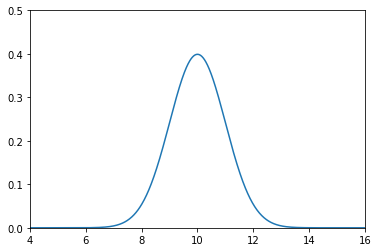

In [2]:
import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10., variance=1., 
                        xlim=(4, 16), ylim=(0, .5));

Mean of readings is 10.033


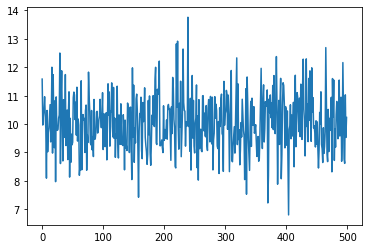

In [4]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = randn(500)*1. + 10.
plt.plot(xs, ys)
print(f'Mean of readings is {np.mean(ys):.3f}')

In [6]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

In [7]:
g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean=4.5, var=0.2**2)
print(g1)
print(g2)

𝒩(μ=3.400, 𝜎²=10.100)
𝒩(μ=4.500, 𝜎²=0.040)


In [8]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

In [9]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

In [10]:
def plot_products(g1, g2): 
    plt.figure()
    product = gaussian_multiply(g1, g2)

    xs = np.arange(5, 15, 0.1)
    ys = [stats.gaussian(x, g1.mean, g1.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g1.mean, g1.var))

    ys = [stats.gaussian(x, g2.mean, g2.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g2.mean, g2.var))

    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend();

In [12]:
from ipywidgets import interact

def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_products(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

In [13]:
class DogSimulation(object):
    def __init__(self, x0=0, velocity=1,
                 measurement_var=0.0,
                 process_var=0.0):
        """ x0 : initial position
            velocity: (+=right, -=left)
            measurement_var: variance in measurement m^2
            process_var: variance in process (m/s)^2
        """
        self.x = x0
        self.velocity = velocity
        self.meas_std = sqrt(measurement_var)
        self.process_std = sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new position of the dog in dt seconds."""
        dx = self.velocity + randn()*self.process_std
        self.x += dx * dt

    def sense_position(self):
        """ Returns measurement of new position in meters."""
        measurement = self.x + randn()*self.meas_std
        return measurement

    def move_and_sense(self):
        """ Move dog, and return measurement of new position in meters"""
        self.move()
        return self.sense_position()

In [20]:
from ipywidgets.widgets import IntSlider
from math import *

np.random.seed(13)

process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x

# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)]

# save output in these lists for plotting
xs, predictions = [], []

process_model = gaussian(velocity, process_var) 

def plot_predictions(p, rng=None, label='Prediction'):
    if rng is None:
        rng = range(len(p))
    plt.scatter(rng, p, marker='v', s=40, edgecolor='r',
                facecolor='None', lw=2, label=label)
    
def plot_measurements(xs, ys=None, dt=None, color='k', lw=1, label='Measurements',
                      lines=False, **kwargs):
    """ Helper function to give a consistant way to display
    measurements in the book.
    """
    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys)*dt, dt)

    plt.autoscale(tight=False)
    if lines:
        if ys is not None:
            return plt.plot(xs, ys, color=color, lw=lw, ls='--', label=label, **kwargs)
        else:
            return plt.plot(xs, color=color, lw=lw, ls='--', label=label, **kwargs)
    else:
        if ys is not None:
            return plt.scatter(xs, ys, edgecolor=color, facecolor='none',
                        lw=2, label=label, **kwargs),
        else:
            return plt.scatter(range(len(xs)), xs, edgecolor=color, facecolor='none',
                        lw=2, label=label, **kwargs),


# perform Kalman filter
x = gaussian(0., 20.**2)
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)
    
def bplot_filter(xs, ys=None, dt=None, c='C0', label='Filter', var=None, **kwargs):
    """ plot result of KF with color `c`, optionally displaying the variance
    of `xs`. Returns the list of lines generated by plt.plot()"""

    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys) * dt, dt)
    if ys is None:
        ys = xs
        xs = range(len(ys))

    lines = plt.plot(xs, ys, color=c, label=label, **kwargs)
    if var is None:
        return lines

    var = np.asarray(var)
    std = np.sqrt(var)
    std_top = ys+std
    std_btm = ys-std

    plt.plot(xs, ys+std, linestyle=':', color='k', lw=2)
    plt.plot(xs, ys-std, linestyle=':', color='k', lw=2)
    plt.fill_between(xs, std_btm, std_top,
                     facecolor='yellow', alpha=0.2)

    return lines

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    plot_predictions(predictions[:i])    
    if step % 3 == 0:
        plot_measurements(zs[:i-1])
        bplot_filter(xs[:i-1])
    elif step % 3 == 1:
        plot_measurements(zs[:i])
        bplot_filter(xs[:i-1])
    else:
        plot_measurements(zs[:i])
        bplot_filter(xs[:i])

    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    plt.legend(loc=2);
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=30, min=1), Output()), _dom_classes=('widget-…